In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, recall_score, accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from joblib import dump, load

# Data preparing

In [35]:
cancer_data = pd.read_csv('../../data/cancer_data_v4.csv')

cancer_data.drop(['WBC', 'EO%', 'EO', 'GLO', 'NEUT%', 'HCT', 'TCH','TBIL', 'IBIL', 'LDH-L'], axis=1, inplace=True)
for fea in cancer_data.columns[6:]:
    median = cancer_data.groupby(['Origin','Age_group', 'A=male B=female'])[fea].median()
    cancer_data.set_index(['Origin','Age_group', 'A=male B=female'], inplace=True)
    cancer_data[fea].fillna(median, inplace=True)
    cancer_data.reset_index(inplace=True)
cancer_data['A=Case, B=Control'] = cancer_data['A=Case, B=Control'].apply(lambda x: 1 if x=='A' else 0)

group_b = cancer_data[cancer_data['Origin']=='B']
group_c = cancer_data[cancer_data['Origin']=='C'].sample(n=212,random_state=0)

data_bc = pd.concat([group_b,group_c], axis=0).sample(frac=1,random_state=0)# 424
data_ac = cancer_data.append(data_bc).drop_duplicates(keep=False).sample(frac=1,random_state=0) # 7368

In [36]:
X1, y1 = data_bc.drop(['Origin','Age_group','A=male B=female','ID', 'A=Case, B=Control', 'Pattern'], axis=1), data_bc['A=Case, B=Control']
X2, y2 = data_ac.drop(['Origin','Age_group','A=male B=female','ID', 'A=Case, B=Control', 'Pattern'], axis=1), data_ac['A=Case, B=Control']

# Random Forest

In [41]:
rf = load('../model/rf_clf')
y_pred = rf.predict(X1)
tn, fp, fn, tp = confusion_matrix(y1, y_pred).ravel()

rf_prob = rf.predict_proba(X1)[:,1]
rf_fpr, rf_tpr, _ = roc_curve(y1, rf_prob)
rf_auc = auc(rf_fpr, rf_tpr)

print("ACC:",accuracy_score(y1, y_pred))
print("REC:",recall_score(y1, y_pred))
print("SPC:",tn/(tn+fp))
print("AUC:",rf_auc)
importances = pd.DataFrame(rf.feature_importances_, columns = ['rf_importance'], index=X1.columns).sort_values(by='rf_importance', ascending=False)

ACC: 0.5377358490566038
REC: 0.08490566037735849
SPC: 0.9905660377358491
AUC: 0.7150787646849414


# XGBoost

In [42]:
xgb = load('../model/xgb_clf')
y_pred = xgb.predict(X1)
tn, fp, fn, tp = confusion_matrix(y1, y_pred).ravel()

xgb_prob = xgb.predict_proba(X1)[:,1]
xgb_fpr, xgb_tpr, _ = roc_curve(y1, xgb_prob)
xgb_auc = auc(xgb_fpr, xgb_tpr)

print("ACC:",accuracy_score(y1, y_pred))
print("REC:",recall_score(y1, y_pred))
print("SPC:",tn/(tn+fp))
print("AUC:",xgb_auc)
importances['xgb_importance'] = pd.DataFrame(xgb.feature_importances_, index=X1.columns)

ACC: 0.5023584905660378
REC: 0.0047169811320754715
SPC: 1.0
AUC: 0.6608001067995729


## RF_mini

In [44]:
rf = load('../model/rf_clf_mini')
y_pred = rf.predict(X2)
tn, fp, fn, tp = confusion_matrix(y2, y_pred).ravel()

rf_prob = rf.predict_proba(X2)[:,1]
rf_fpr2, rf_tpr2, _ = roc_curve(y2, rf_prob)
rf_auc2 = auc(rf_fpr2, rf_tpr2)

print("ACC:",accuracy_score(y2, y_pred))
print("REC:",recall_score(y2, y_pred))
print("SPC:",tn/(tn+fp))
print("AUC:",rf_auc2)
importances['rf_mini_importance'] = pd.DataFrame(rf.feature_importances_, index=X2.columns)

ACC: 0.6669381107491856
REC: 0.6356425171866738
SPC: 0.6999442275515895
AUC: 0.7298051975438887


## XGB_mini

In [45]:
xgb = load('../model/xgb_clf_mini')
y_pred = xgb.predict(X2)
tn, fp, fn, tp = confusion_matrix(y2, y_pred).ravel()

xgb_prob = xgb.predict_proba(X2)[:,1]
xgb_fpr2, xgb_tpr2, _ = roc_curve(y2, xgb_prob)
xgb_auc2 = auc(xgb_fpr2, xgb_tpr2)

print("ACC:",accuracy_score(y2, y_pred))
print("REC:",recall_score(y2, y_pred))
print("SPC:",tn/(tn+fp))
print("AUC:",xgb_auc2)
importances['xgb_mini_importance'] = pd.DataFrame(xgb.feature_importances_, index=X2.columns)

ACC: 0.6867535287730727
REC: 0.6485986250661026
SPC: 0.7269938650306749
AUC: 0.7642652562421048


In [47]:
# importances.to_csv('../../data/featureImportance.csv')

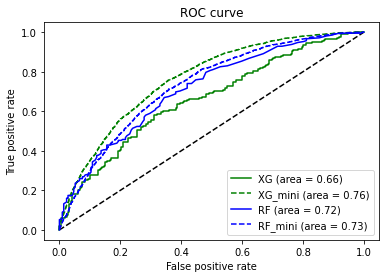

In [46]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(xgb_fpr, xgb_tpr, label='XG (area = %0.2f)' % xgb_auc, color='g')
plt.plot(xgb_fpr2, xgb_tpr2, label='XG_mini (area = %0.2f)' % xgb_auc2, color='g', linestyle="--")
plt.plot(rf_fpr, rf_tpr, label='RF (area = %0.2f)' % rf_auc, color='b')
plt.plot(rf_fpr2, rf_tpr2, label='RF_mini (area = %0.2f)' % rf_auc2, color='b', linestyle="--")
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()